# Worksheet 10: Predictive versus generative modelling


### Learning objectives
By the end of this section, students will be able to:

- Give examples of questions that can be answered by generative models and others that can be answered by predictive models.
- Discuss how the research question being asked impacts the statistical modelling procedures.
- Discuss why the model obtained directly from lasso is not the most suitable model for generative modelling and how post-lasso is one way to address this problem.
- Write a computer script to perform post-lasso and use it to estimate a generative model.
- Discuss post inference problems (e.g., double dipping into the data set) and current practical solutions available to address these (e.g., data-splitting techniques).
- Write a computer script to apply currently available practical solutions to post inference problems.
- Discuss how the research question being asked impacts the communication of the results.


In [1]:
library(tidyverse)
library(glmnet)
library(broom)
library(leaps)
library(repr)
library(faraway)
library(mltools)

options(repr.plot.width=10, repr.plot.height=8)
source("tests_worksheet_10.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8


Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na



Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked fr

# PART I: Model selection (cont.)

## In worksheet_09: 

### Select a model using *stepwise* algorithms

- these are *greedy* algorithms 

- results depend on the order in which variables are selected 

- variables are either *in* (i.e., estimated coefficient different from zero) or *out* (i.e., estimated coefficient equal to zero)

## In this worksheet:

- can we use the selected model to make inference about the population?

- can we use shrinkage methods to select a model and make inference?

Let's examine these problems using a simulation study.

## PART I: Inference after model selection

### 1. Can we make inference using the selected models??

In this course, we learned how to make inference (e.g, calculate confidence interval and hypotheses tests) for a fixed model. However, when we apply a model selection algorithm, we are searching for the combination of variables that will give us the best model (according to a given metric). So the variables in our final models are not fixed; instead, they are selected adaptively based on **the data at hand**. 

Two questions arise then: 

1. Do these model selection algorithms affect the inference about the parameters of the model? 

2. Is the way we interpret the models still the same? 

Now we will investigate the first question. For now, let's focus on the forward selection. 

**Question 1.0**<br>

In this exercise, we will explore if the forward selection strategy affects the inference results. For this purpose, we are going to use a simulation study in order to know the truth. Here's what we are going to do: 

1. We are going to consider a response variable $Y$ and $p=10$ independent variables. However, none of the generated variables will have an effect on $Y$. In other words, in this simulation study, we expect the intercept only model to be better than any LR that includes any of the independent variables.


2. Generate 100 observations of each variable (the response and the 10 independent variables) from a Normal distribution.


3. Apply the forward selection algorithm to select at most 3 variables among the 10 available. We restrict the size to 3 to shorten the computation time.
    - The metric we are going to use is the adjusted $R^2$.

4. Use the selected model to make inference about the population. Recall that none of the independent variables is related to the response Y. However, due to randomness in the sample used, we may still (incorrectly) find a model that it's statistically better than the intercept only model! 

5. Replicate this study 1,000 times and compute the type I error rate. 

> Note that we are generating 1,000 datasets, all at once!! We will use the `map` function to apply a function to each dataset.

*Run the cells below to generate the datasets.* 

In [2]:
# Run this cell before continuing 
set.seed(20211113)

n <- 100    # sample size
p <- 10     # number of variables
rep <- 1000 # number of replications

means <- runif((p+1), 3, 10) # means for the Normal distribution 
                             # that will be used to generate 
                             # p covariates and a response Y   

dataset <- as_tibble(
  data.frame(
    matrix(
      round(rnorm((p + 1) * n * rep, 
            means, 10), 2), 
      ncol = p+1, 
      byrow = TRUE
    )
  ) %>% 
  rename(Y = X11) %>% 
  mutate(replicate = rep(1:rep, n)) %>% 
  arrange(replicate) 
)

head(dataset)

X1    X2    X3    X4    X5    X6    X7     X8    X9    X10    Y     replicate
1  8.07  8.86 15.62  3.37  2.79  0.77   5.65 -8.65  7.52   9.39 -6.99 1        
2 -3.96  3.59 15.84  3.05  1.38 -0.01 -14.54  7.11 -9.83  -3.03 21.06 1        
3 -5.03 -2.62  7.83  9.05 11.52  9.45  -4.41 11.92 13.61  25.83 -2.80 1        
4  5.40  7.38 -1.07  2.93 31.07  8.13   5.13 19.39  9.98  -3.65  0.07 1        
5  4.61 23.21 11.92 -1.83 16.86 15.95  -5.94  8.37 13.94  13.96 -0.37 1        
6 -3.96 12.62 21.53 -1.47 -6.53  6.80  17.57 -1.70 -1.25 -16.95 23.17 1

In [3]:
dim(dataset)

[1] 100000     12

**Question 1.1 - Warm up**<br>
{points: 1}

To help you visualize the code abstraction, let's do a more intuitive exercise. 
Using the `dataset` tibble, fit one `lm` for each replicate using all 10 covariates to explain $Y$. Store the `lm` models in a column named `models`.

_Assign your data frame to an object called `full_models`. Your data frame should have three columns: `replicate`, `data`, and `models`._

In [4]:
# full_models <- 
#     ... %>% 
#     group_by(...) %>% 
#     nest() %>% 
#     mutate(models = map(...))


# your code here
full_models <- 
    dataset %>% 
    group_by(replicate) %>% 
    nest() %>% 
    mutate(models = map(data, ~lm(Y ~ ., data = .x)))

# Try exploring the columns of your data frame. 
# Check full_models$data[[1]] and full_models$models[[1]]

In [5]:
full_models$models[[1]]


Call:
lm(formula = Y ~ ., data = .x)

Coefficients:
(Intercept)           X1           X2           X3           X4           X5  
    4.65857      0.05977      0.04595     -0.02462      0.14726     -0.06335  
         X6           X7           X8           X9          X10  
   -0.04047      0.08451      0.01575     -0.06840     -0.11245  


In [6]:
test_1.1()

Test passed 😀
Test passed 🌈
Test passed 🌈
Test passed 🌈
Test passed 🥳
[1] "Success!"


To help speed things up, we created a function for you that receives a data frame, runs the forward selection algorithm to select at most 3 variables, and fit LS on the selected variables. 

*Read and run the cell below to create such a function.*

In [7]:
forward_selection_function <- function(dataset){
    sel_model <- regsubsets(x = Y ~ ., 
                    nvmax = 3,
                    data = dataset,
                    method = "forward",
)

sel_model_summary <- summary(sel_model)
    
adj_r2_min = which.max(sel_model_summary$adjr2) 
selected_var <- names(coef(sel_model, adj_r2_min))[-1]
data_subset <- dataset %>% select(all_of(selected_var),Y)

selected_model <- lm(Y ~ .,
  data = data_subset
)
    return(selected_model)
    }

**Question 1.2**<br>
{points: 1}

The function `forward_selection_function` will be used to select and fit a model on a given data set using LS. We will then compare the selected model to the intercept only model using an $F$-test. Which null hypothesis will be tested:

**A**. The coefficient of the first variable selected equals zero.

**B**. The coefficient(s) of all selected variables equal zero.

**C**. The selected variables equal zero.

**D**. The intercept equals zero.

*Assign your answer to an object called answer1.2. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"`, surrounded by quotes.*

In [8]:
# answer1.2 <- 

# your code here
answer1.2 <- "B"

In [9]:
test_1.2()

Test passed 😸
Test passed 🥇
Test passed 😸
[1] "Success!"


**Question 1.3**<br>
{points: 1}

Using the function `map`, apply the `forward_selection_function` to each generated dataset in the tibble `dataset`, identified by the variable `replicate`. Store each fitted model in a column named `fs_model`. 

> Note that there are 1000 fitted models, one for each dataset generated in **Question 1.0**!! 

Then, use the function `map_dbl` to compare each selected model to the intercept only model and extract the $p$-value of each $F$-test. Store the 1000 $p$-values in a column named `F_pvalue`.

_Assign your data frame to an object called `forward_selection_F`. Your data frame should have four columns: `replicate`, `data`, `fs_model`, and `F_pvalue`._

In [10]:
# forward_selection_F <- 
#     ... %>% 
#     group_by(...) %>% 
#     nest() %>% 
#     mutate(
#         ... = map(...), 
#         ... = ..._dbl(...)
#     )

# your code here
forward_selection_F <- 
    dataset %>% 
    group_by(replicate) %>% 
    nest() %>% 
    mutate(
        fs_model = map(data, forward_selection_function), 
        F_pvalue = map_dbl(fs_model,~ glance(.x) %>% pull(p.value)))

head(forward_selection_F, 2)

replicate
1 1        
2 2        
  data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [11]:
test_1.3()

Test passed 🥇
Test passed 🥇
Test passed 🎉
Test passed 😀
Test passed 🎉
[1] "Success!"


**Question 1.4** 
<br> {points: 1}

Knowing that none of generated independent variables are relevant to model $Y$, what proportion of tests would you expect to wrongly reject the null hypothesis that the coefficients of all the selected variables are zero?

_Assign your answer to an object called `nominal_type_I_error`. Your answer should be a single number._

In [12]:
# nominal_type_I_error <- ...

# your code here
nominal_type_I_error <- 0.05

nominal_type_I_error

[1] 0.05

In [13]:
test_1.4()

Test passed 😸
Test passed 🥳
Test passed 😸
[1] "Success!"


**Question 1.5** 
<br> {points: 1}

Check the proportions of $p$-values computed from the $F$-tests stored in the `forward_selection_F` tibble that are below the 5% significance level. 

_Assign your answer to an object called `forward_selection_type_I_error`. Your answer should be a single number._

In [14]:
# forward_selection_type_I_error <- 
#     ... %>% 
#     ungroup() %>% 
#     summarise(...(... < 0.05)) %>% 
#     pull()

# your code here
forward_selection_type_I_error <- 
    forward_selection_F %>% 
    ungroup() %>% 
    summarise(prop_below_0_05 = mean(F_pvalue < 0.05)) %>% 
    pull()


forward_selection_type_I_error

[1] 0.463

In [15]:
test_1.5()

Test passed 😀
Test passed 😀
Test passed 😀
[1] "Success!"


### Class discussion 
Contrast the `forward_selection_type_I_error` and `nominal_type_I_error`. Are they similar? Why do you think this is happening. 

### 2. The double use of data

The Type I Error rate from the tests run using the fitted selected models was significantly higher than the nominal level of 5%. Why? 

Well, if we are looking for the most relevant covariates in a dataset, it is not surprising that we frequently find these covariates significant. In our case above, the *F-statistic* compares the reduction of SSR after adding the selected variables to an intercept-only model. But the variables selected were those that reduced the SSR (or increased the adjusted $R^2$) **in the sample at hand**. Hence, we have a much higher chance of wrongly rejecting $H_0$.  

**The problem**: we are using the **same sample** to find the variables and fit the model. 

**A possible solution**: what if we split the dataset into two parts, one used for model selection and the other one used for inference? Would that solve the problem? 

Let's investigate! 

**Question 2.0** 
<br> {points: 1}

In this exercise we are again going to use the tibble `dataset`. But this time we are going to split our dataset into two parts. We are going to use one part to select a model, and the other part for inference. Since the sample sizes has changed, to compare strategies, we'll also fit the selected model and test it on the first set.

> For this exercise, let's split the dataset in half. Note that other options are possible.

Here's what you need to do: 

1. Using the first 50 observations, run the forward selection algorithm to select at most 3 variables and fit a LS on the selected variables. Store the selected model in `fs_model` column. 


2. Run an $F$-test to compare the selected model to an intercept only model and extract the $p$-value. Store the 1000 values in a column called `F_fs`.


3. Fit the model selected in Step 1 using the 50 remaining observations and save it in a column named `inference_model`. Also, extracts the $p$-value of the $F$-test for the `inference_model` and stores it in a column called `F_pvalue`. 

> Note that using the `map` functions you can perform these steps at once for the 1000 datasets.

_Assign your data frame to an object called `fs_error_split`. Your data frame should have 6 columns: `replicate`, `data`, `fs_model`, `F_fs`, `inference_model`, `F_pvalue`._

In [16]:
set.seed(20211113) # Do not change this.

# fs_error_split <- 
#     ... %>% 
#     ... %>% 
#     ... %>% 
#     mutate(
#         fs_model = ...(..., .f = function(d) forward_selection_function(d %>% head(50))), 
#         F_fs = ...,
#         inference_model = map2(.x = ..., .y = ..., ~ update(.y, .~., data = .x %>% tail(50))), 
#         F_pvalue =  ...)
#     )

# your code here
fs_error_split <- 
     dataset %>% 
     group_by(replicate) %>% 
     nest() %>% 
     mutate(
         fs_model = map(data, .f = function(d) forward_selection_function(d %>% head(50))), 
         F_fs = map_dbl(.x = fs_model, ~ glance(.x) %>% pull(p.value)),
         inference_model = map2(.x = data, .y = fs_model, ~ update(.y, .~., data = .x %>% tail(50))), 
         F_pvalue = map_dbl(.x = inference_model, ~ glance(.x) %>% pull(p.value))
     )

    
head(fs_error_split) %>% 
    select(replicate, F_fs, F_pvalue)

replicate F_fs       F_pvalue  
1 1         0.26586291 0.86613750
2 2         0.24751748 0.09167340
3 3         0.16679479 0.09517505
4 4         0.12646876 0.34640254
5 5         0.04254474 0.82736673
6 6         0.11243868 0.50448716

In [17]:
test_2.0()

Test passed 😸
Test passed 🥇
Test passed 🌈
Test passed 🌈
Test passed 🥇
[1] "Success!"


**Question 2.1** 
<br> {points: 1}

Check the proportions of $p$-value of the $F$-test in the `F_fs` column that are below the 5% significance level. Note that these tests were run using the the first split of the data used to select the model.

> Hint: you've done something similar in **Question 1.5**

_Assign your answer to an object called `fs_split1_type_I_error`. Your answer should be a single number._

In [18]:
# fs_split1_type_I_error <- ... 

# your code here
fs_split1_type_I_error <- mean(fs_error_split$F_fs < 0.05)

fs_split1_type_I_error

[1] 0.444

In [19]:
test_2.1()

Test passed 🥇
Test passed 😸
Test passed 🥇
[1] "Success!"


**Question 2.2** 
<br> {points: 1}

Check the proportions of $p$-value of the $F$-test in the `F_pvalue` column that are below the 5% significance level. Note that these tests were run using the the second split of the data that was *not used* to select the model.


_Assign your answer to an object called `fs_split2_type_I_error`. Your answer should be a single number._

In [20]:
# fs_split2_type_I_error <- ... 

# your code here
fs_split2_type_I_error <- mean(fs_error_split$F_pvalue < 0.05)
fs_split2_type_I_error

[1] 0.057

In [21]:
test_2.2()

Test passed 🥇
Test passed 🌈
Test passed 🎉
[1] "Success!"


**Question 2.3**
<br>{points: 1}

True or false?

If we split the data and use different part for model selection and inference, the type I error of the F-test after the forward selection is close to the significance level. 

_Assign your answer to an object called `answer2.3`. Your answer should be either "true" or "false", surrounded by quotes._

In [22]:
# answer2.3 <- ...

# your code here
answer2.3 <- "true"

In [23]:
test_2.3()

Test passed 🥳
Test passed 🥳
Test passed 🥇
[1] "Success!"


## PART II. Lasso - two problems

The problem we discussed with the forward selection *also happens with Lasso*. Similarly, we can address it by splitting the dataset -- one part for selecting variables using lasso and the other for fitting the model for inference. 

However, there's another problem with Lasso for inference. Lasso's estimators are biased. Bias estimators are estimators whose sampling distributions are not centred on the true value of the parameter. 

To study this problem, we are going to use a new simulation, Our population is generated below and it is stored in `lasso_sim` tibble.

The population was generated such that:

$$
E[Y|X_1, X_2] = 75X_1 - 5 X_2 + 0 X_3
$$ 

Therefore, the true parameters are $\beta_1=75$ and $\beta_2=-5$. Note that $\beta_3$ is not a relevant variable and, hopefully, Lasso will remove it from the model. 

In [24]:
# Run this cell before continuing 

set.seed(20211113) # Do not change this.

n <- 1000    # sample size
rep <- 1000 # number of replications

lasso_sim <- 
    tibble(
        X1 = round(
                rnorm(n * rep, 0, 10), 
                2),
        X2 = round(
                rnorm(n * rep, 0, 10), 
                2),
        X3 = round(
                rnorm(n * rep, 0, 20), 
                2),
        Y = round(75 * X1 - 5*X2 + rnorm(n * rep, 0, 400),2)) %>% 
    mutate(replicate = rep(1:rep, n)) %>% 
    arrange(replicate) 


head(lasso_sim)

X1     X2     X3     Y        replicate
1  -9.52   6.99   6.88 -1026.24 1        
2  -4.24  10.41 -11.46  -586.31 1        
3 -21.23 -18.31  20.00  -743.30 1        
4  12.02  -7.12  -0.47   863.88 1        
5   1.88  13.89  18.47  -154.27 1        
6 -10.18  10.26  -2.86 -1063.06 1

**Question 3.0**<br>
{points: 1}

Using the `lasso_sim` tibble, fit a LASSO model for each replicate. For simplicity, we'll use $\lambda=30$ in all models. 

> However, in practice, it is not recommended to fit LASSO at a given lambda value. 

Store the models in a column named `lasso_models`. 

_Assign your data frame to an object called `lasso_study`. Your data frame should have four columns: `replicate`, `data`, and `lasso_model`._

In [25]:
# lasso_study <- 
#     ... %>% 
#     ... %>% 
#     ... %>% 
#     mutate(
#         lasso_model = ...(...,
#                           ~...(.x %>% select(-Y) %>% as.matrix(), 
#                                   .x %>% select(Y) %>% as.matrix(), 
#                                   alpha = ..., 
#                                   lambda = ...)))

# your code here
lasso_study <- 
    lasso_sim %>%
    group_by(replicate) %>% 
    nest() %>% 
    mutate(
        lasso_model = map(.x = data,
                          ~glmnet(.x %>% select(-Y) %>% as.matrix(), 
                                  .x %>% select(Y) %>% as.matrix(), 
                                  alpha = 1, 
                                  lambda = 30)))

lasso_study %>% head(2)

replicate
1 1        
2 2        
  data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [26]:
test_3.0()

Test passed 🎊
Test passed 🥇
Test passed 🎉
Test passed 🌈
Test passed 🎉
[1] "Success!"


**Question 3.1**<br>
{points: 1}

Extract the coefficient for `beta_1` from each `lasso_model` in the `lasso_study` tibble. Store the coefficients in a column name `lasso_beta1` in the same `lasso_study` tibble. 

In [27]:
# lasso_study <- 
#     ... %>% 
#     ...

# your code here
lasso_study <- lasso_study %>%
  mutate(
    lasso_beta1 = map_dbl(lasso_model, ~ coef(.x)[2])
  )

lasso_study %>% 
    select(-data) %>% 
    head()

replicate
1 1        
2 2        
3 3        
4 4        
5 5        
6 6        
  lasso_model                                                                                                                                                                                                                               
1 17.68002, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 2, 3, 1, 30, 0.7832518, 737570112, 4, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000 
2 7.783486, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 2, 3, 1, 30, 0.7662044, 667895360, 4, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000 
3 -7.456994, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 2, 3, 1, 30, 0.7575035, 672723659, 3, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000
4 -3.932344, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 1, 3, 1, 30, 0.7613222, 704316700, 3, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000
5 -10.18447, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 2, 3, 1, 30, 0.786506, 731148523, 4, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000 
6 -33.50037, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 2, 3, 1, 30, 0.7619526, 714571595, 4, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000
  lasso_beta1
1 71.17269   
2 71.67783   
3 70.17038   
4 71.89095   
5 71.59488   
6 71.55317

In [28]:
test_3.1()

Test passed 😀
Test passed 🥇
Test passed 😸
Test passed 🥇
Test passed 🥇
[1] "Success!"


**Question 3.2**
<br> {points: 1}

Plot the sampling distribution of $\hat{\beta}_1$ obtained by Lasso.


_Assign your plot to an object called `lasso_beta1_sampling_dist`._

List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 18
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


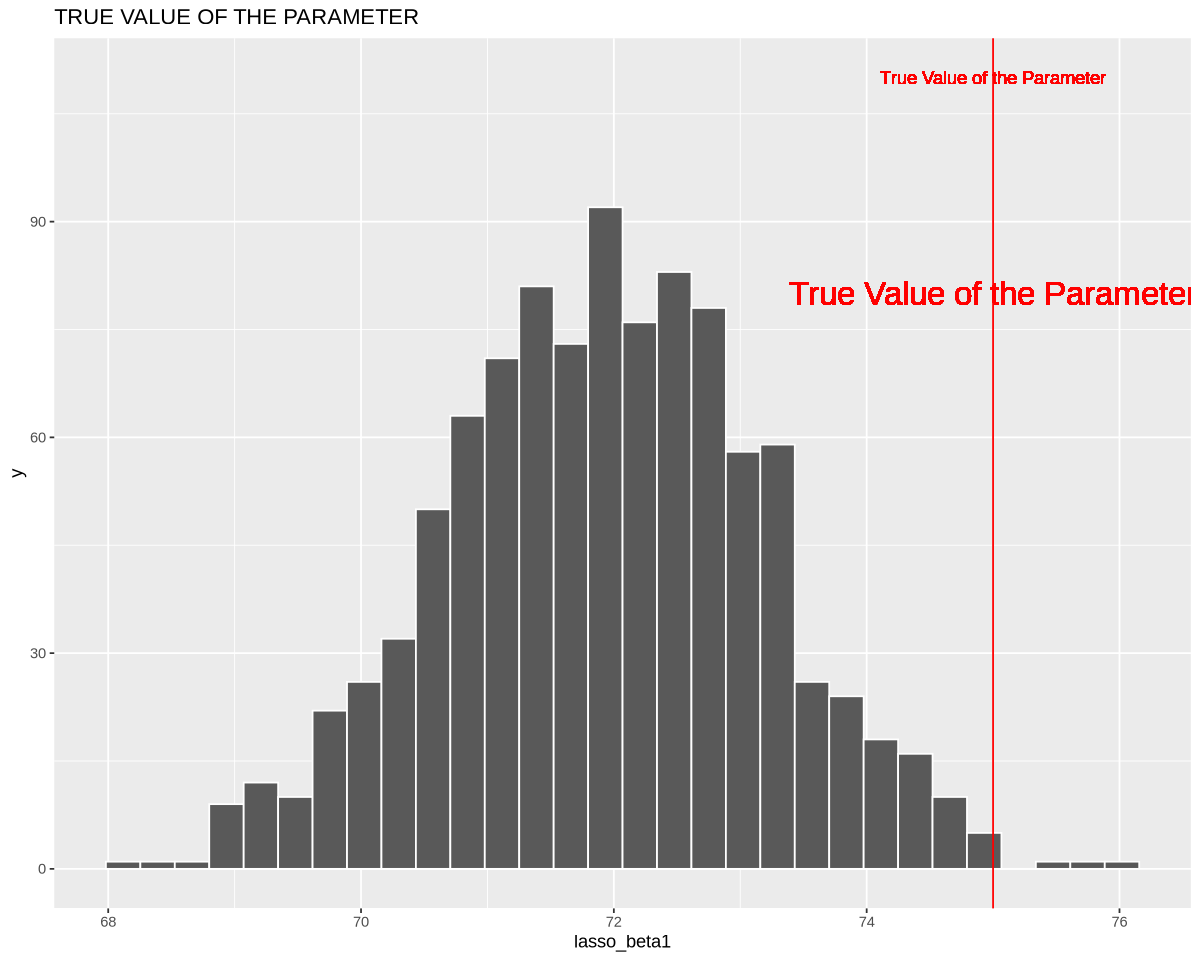

In [29]:
# lasso_beta1_sampling_dist <- 
#     lasso_study %>% 
#     ggplot() + 
#     geom_...(aes(...), color='white') +
#     geom_vline(xintercept = 75, color = 'red') + 
#     geom_text(aes(75, 110), label = "True Value of the Parameter", color = 'red') 
#     geom_text(aes(75, 80), label = "True Value of\n the Parameter", color = 'red', size = 7) +
#     theme(text = element_text(size = 18))

# your code here
lasso_beta1_sampling_dist <- lasso_study %>%
      ggplot() + 
      geom_histogram(aes(x = lasso_beta1), color = 'white') +
      geom_vline(xintercept = 75, color = 'red') + 
      geom_text(aes(x = 75, y = 110), label = "True Value of the Parameter", color = 'red') +
      geom_text(aes(x = 75, y = 80), label = "True Value of the Parameter", color = 'red', size = 7) +
      ggtitle("TRUE VALUE OF THE PARAMETER")
      theme(text = element_text(size = 18))

lasso_beta1_sampling_dist

In [30]:
test_3.2()

Test passed 🎉
Test passed 🎊
Test passed 🌈
Test passed 😀
Test passed 😀
Test passed 🎉
Test passed 🎉
[1] "Success!"


**Question 3.3**
<br>{points: 1}

True or false?

The sampling distribution of the lasso estimator of $\beta_1$ is centered around the true $\beta_1$.

_Assign your answer to an object called `answer3.3`. Your answer should be either "true" or "false", surrounded by quotes._

In [31]:
# answer3.3 <- ...

# your code here
answer3.3 <- "false"

In [32]:
test_3.3()

Test passed 🥳
Test passed 🥳
Test passed 😀
[1] "Success!"


**Question 3.4**<br>
{points: 1}

One way to correct the bias of the Lasso's estimated coefficients is to re-fit the model using LS and the variables selected by LASSO. In other words, we use LASSO only to select variables and ignore the estimated coefficients. We then re-estimate the coefficients of the selected variables using regular least squares. 

In the cell below we have done it for you. Here's what we did:

1. Add a new column to `lasso_study` tibble, named `lasso_selected_covariates` with the covariates selected by LASSO (i.e., with coefficients different from 0).


2. We fitted a linear model using `lm` (regular least square) and only the `lasso_selected_covariates`.


3. We extracted $\beta_1$ from the `lm` model, and saved it on a column called `ls_beta1`.

Your job is to plot the sampling distribution of $\hat{\beta}_1$ obtained by the regular least square, using the variables selected by LASSO.

_Assign your plot to an object called `post_lasso_lm_beta1_sampling_dist`._

In [33]:
# Run this cell before continuing

lasso_study <- 
    lasso_study %>% 
    mutate(
        lasso_selected_covariates = map(.x = lasso_model, 
                                        ~as_tibble(
                                                as.matrix(coef(.x)),
                                                rownames='covariate') %>%
                                                filter(covariate != '(Intercept)' & abs(s0) > 10e-6) %>% 
                                                pull(covariate)),
        ls_fit = map2(.x = data, .y = lasso_selected_covariates,
                     ~lm(Y ~ ., data = .x[,c(.y, 'Y')])),
        ls_beta1 = map_dbl(.x = ls_fit, ~tidy(.x) %>% filter(term == 'X1') %>% pull(estimate)))


lasso_study %>% 
    select(-data, -lasso_model, -ls_fit) %>% 
    head()

replicate lasso_beta1 lasso_selected_covariates ls_beta1
1 1         71.17269    X1, X2                    74.15431
2 2         71.67783    X1, X2                    74.78584
3 3         70.17038    X1, X2                    73.19749
4 4         71.89095    X1                        74.95937
5 5         71.59488    X1, X2                    74.59362
6 6         71.55317    X1, X2                    74.72685

List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 18
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


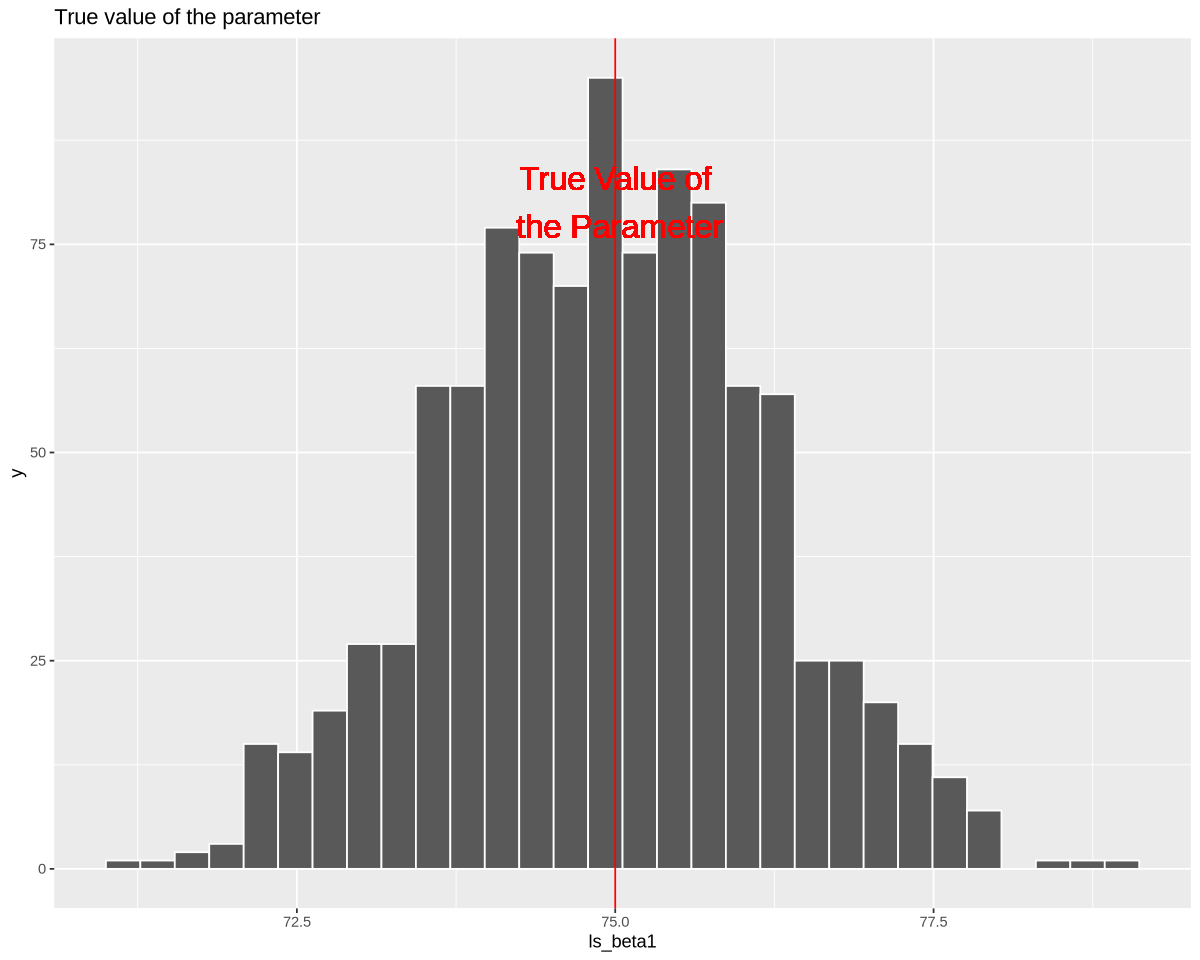

In [38]:
# post_lasso_lm_beta1_sampling_dist <- 
#     lasso_study %>% 
#     ggplot() + 
#     geom_...(aes(...), color='white') +
#     geom_vline(xintercept = 75, color = 'red') + 
#     geom_text(aes(75, 80), label = "True Value of\n the Parameter", color = 'red', size = 7) +
#     theme(text = element_text(size = 18))

# your code here
post_lasso_lm_beta1_sampling_dist <- 
    lasso_study %>% 
    ggplot() + 
    geom_histogram(aes(x = ls_beta1), color='white') +
    geom_vline(xintercept = 75, color = 'red') + 
    geom_text(aes(75, 80), label = "True Value of\n the Parameter", color = 'red', size = 7) +
    ggtitle("True value of the parameter")
    theme(text = element_text(size = 18))

post_lasso_lm_beta1_sampling_dist

In [39]:
test_3.4()

Test passed 🥳
Test passed 😀
Test passed 🎊
Test passed 🥇
Test passed 😸
Test passed 🎉
Test passed 🎉
[1] "Success!"


## Conclusions

#### Post-inference problem:

- we can not use the same data to select variables of the model and to conduct inference ("doble dipping"). 

- the inference results given by the `lm` are not valid (as seen in the first part of the worksheet). 

- if we split the data, we can use one part to select and the other part to estimate and build tests.

- more sophisticated methods have been proposed to address this problem (beyond the scope of this course).


#### Lasso has two problems:

- **Biased estimators**: we can take care of this by fitting regular least squares on the variables selected by Lasso. This approach is called **post-lasso**.

- **Post-inference**: fitting a LS regression after LASSO, we are using the data to select the variables as well as to conduct inference. We cannot rely on the inference given by the `lm`, unless we split the data to take care of this problem.